In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

2025-11-28 16:53:46.022629: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 16:53:46.023677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 16:53:46.050115: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 16:53:46.050688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 16:53:46.517864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
import umap
from sklearn.utils.validation import check_array


df = pd.read_csv("NYSE.csv")

# Целевая переменная: Industry 
df = df[df['Industry'].notna() & (df['Industry'] != '')]
y = df['Industry'].astype('category').cat.codes
industry_names = dict(enumerate(df['Industry'].astype('category').cat.categories))

# Выбранные признаки (6+ непрерывных)
feature_cols = [
     'Quick Ratio', 'Current Ratio', 'Net Debt to Capital', 
    'Analyst Target Upside', 'Beta (5y)', 'Debt to Equity'
]


X = df[feature_cols].copy()

# Очистка: удаление символов и конвертация в float
def clean_col(series):
    return (
        series
        .astype(str)
        .str.replace(r'[\$\%,x]', '', regex=True)          # убираем $, %, x
        .str.replace(r' Upside| Downside', '', regex=True) # убираем текст
        .str.replace(r'\s+', '', regex=True)               # убираем пробелы
        .replace({'': np.nan, 'blank': np.nan})
    )

for col in feature_cols:
    X[col] = clean_col(X[col])
    X[col] = pd.to_numeric(X[col], errors='coerce')  # ← ключевой шаг

# Импутация и фильтрация
# Удалим признаки с >90% пропусков 
X = X.loc[:, X.isna().mean() < 0.9]

# Заполним пропуски медианой
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Удалим признаки с нулевой дисперсией
selector = VarianceThreshold(threshold=1e-8)
X_filtered = selector.fit_transform(X_imputed)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Финальная чистка от не-finite значений
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

# Проверка через sklearn
X_clean = check_array(X_scaled, ensure_all_finite=True)
print(f"Shape: {X_clean.shape}, Classes: {len(np.unique(y))}")

Shape: (152, 6), Classes: 8


In [83]:
#  Снижение размерности

methods = {}

print("Запуск MDS...")
methods['MDS'] = (
    MDS(n_components=2, random_state=42, max_iter=300).fit_transform(X_clean),
    MDS(n_components=3, random_state=42, max_iter=300).fit_transform(X_clean)
)

print("Запуск ISOMAP...")
methods['ISOMAP'] = (
    Isomap(n_components=2, n_neighbors=10).fit_transform(X_clean),
    Isomap(n_components=3, n_neighbors=10).fit_transform(X_clean)
)

print("Запуск LLE...")
methods['LLE'] = (
    LocallyLinearEmbedding(n_components=2, n_neighbors=10, method='standard', random_state=42).fit_transform(X_clean),
    LocallyLinearEmbedding(n_components=3, n_neighbors=10, method='standard', random_state=42).fit_transform(X_clean)
)

print("Запуск t-SNE...")
methods['t-SNE'] = (
    TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000).fit_transform(X_clean),
    TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000).fit_transform(X_clean)
)

print("Запуск UMAP...")
methods['UMAP'] = (
    umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_clean),
    umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_clean)
)

Запуск MDS...
Запуск ISOMAP...
Запуск LLE...
Запуск t-SNE...
Запуск UMAP...


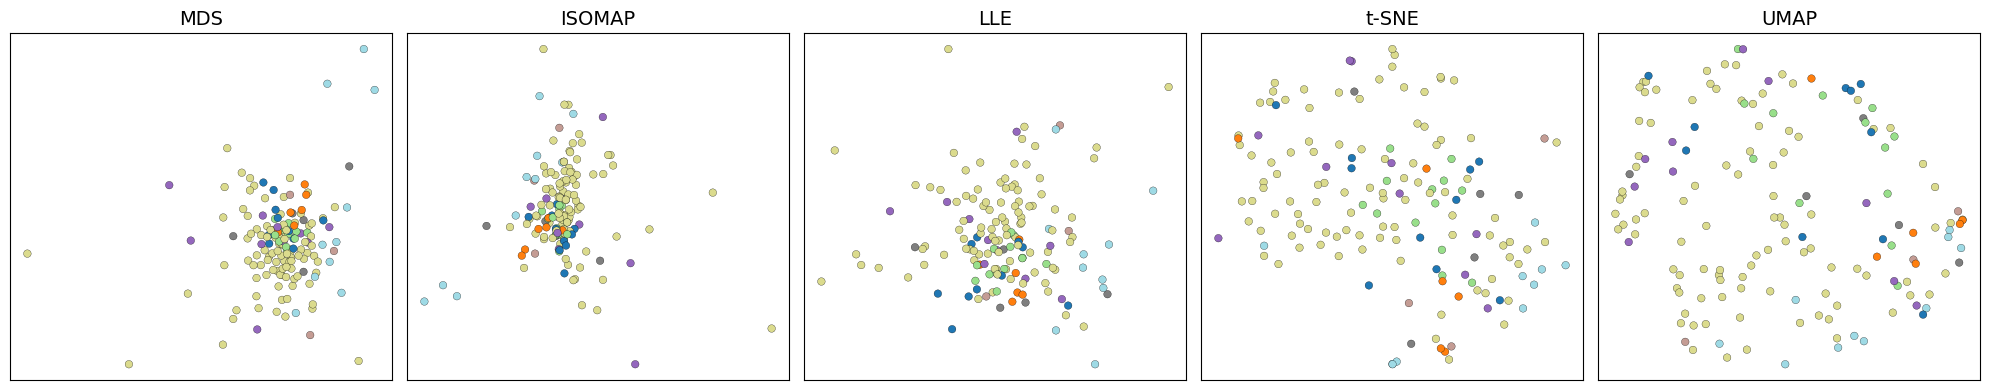

In [84]:
# --------------------------------------------------------------
# Визуализация 2D
# --------------------------------------------------------------
plt.figure(figsize=(20, 4))
for i, (name, (X2, _)) in enumerate(methods.items()):
    plt.subplot(1, 5, i + 1)
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap='tab20', s=30, edgecolor='k', linewidth=0.2)
    plt.title(name, fontsize=14)
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

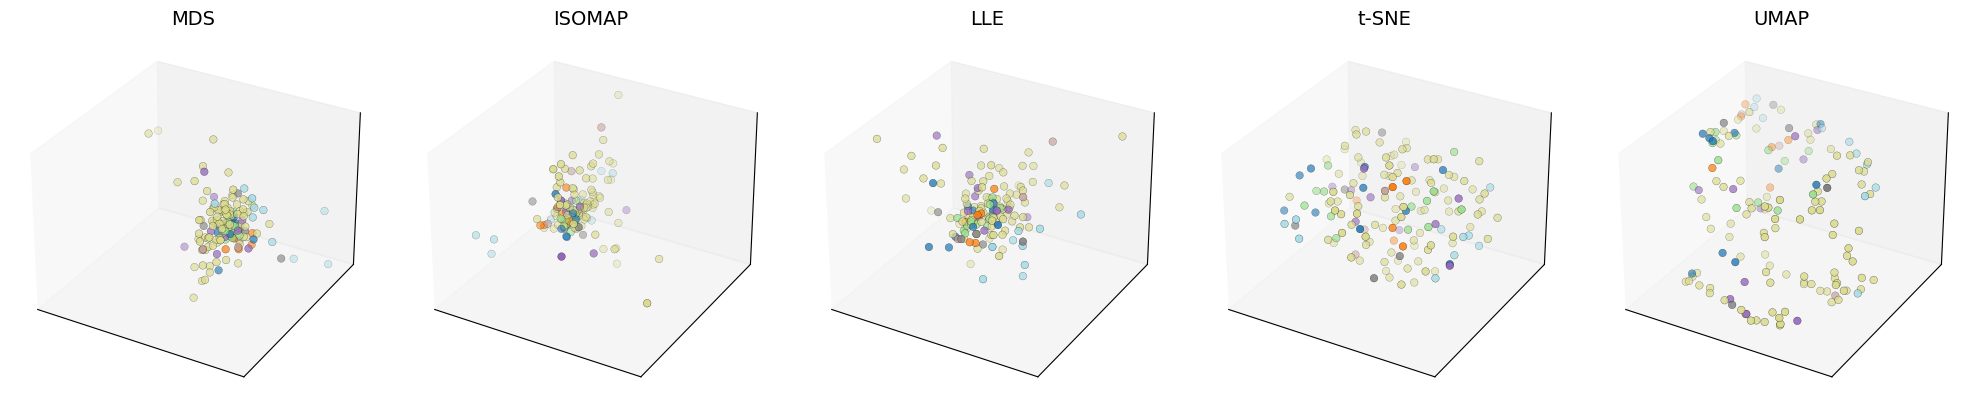

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Настройка фигуры
fig = plt.figure(figsize=(20, 4))

for i, (method_name, (_, X3)) in enumerate(methods.items()):
    ax = fig.add_subplot(1, 5, i + 1, projection='3d')
    scatter = ax.scatter(
        X3[:, 0], X3[:, 1], X3[:, 2],
        c=y,                     # цвет по классу (Industry)
        cmap='tab20',            # достаточно цветов для ~10–15 классов
        s=30,
        edgecolor='k',           # тонкая чёрная окантовка для чёткости
        linewidth=0.2
    )
    ax.set_title(method_name, fontsize=14)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

plt.tight_layout()
plt.show()

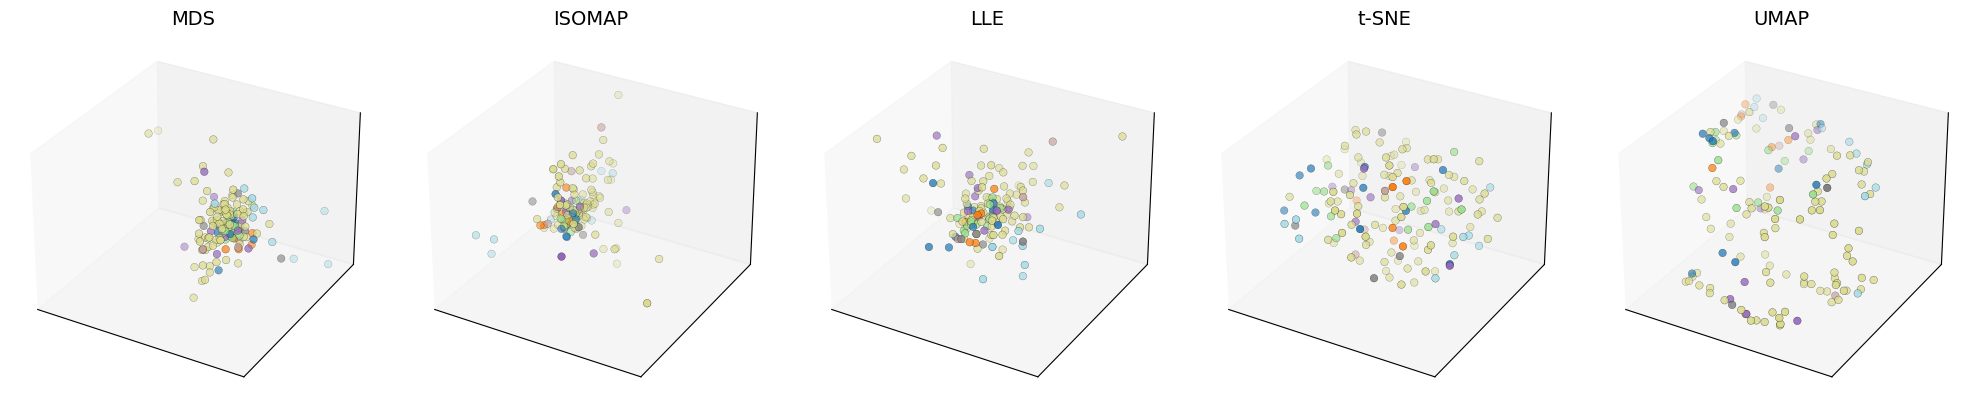

In [86]:
from mpl_toolkits.mplot3d import Axes3D

# Создаем фигуру
fig = plt.figure(figsize=(20, 4))

for i, (method_name, (_, X3)) in enumerate(methods.items()):
    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    scatter = ax.scatter(
        X3[:, 0], X3[:, 1], X3[:, 2],
        c=y,
        cmap='tab20',
        s=30,
        edgecolor='k',
        linewidth=0.2
    )
    ax.set_title(method_name, fontsize=14)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    # Убираем оси для чистоты визуализации

plt.tight_layout()
plt.show()

In [87]:
embeddings = {'UMAP': X_umap_2d, 't-SNE': X_tsne_2d}
# --------------------------------------------------------------
# 3. Кластеризация и анализ состава кластеров
# --------------------------------------------------------------
def analyze_clustering(X_2d, y_true, method_name, k_values=range(3, 7)):
    industry_names = df['Industry'].astype('category').cat.categories
    n_classes = len(industry_names)
    
    results = {}
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_2d)
        
        # Считаем доли классов в кластерах
        comp = []
        for cluster in range(k):
            mask = labels == cluster
            y_cluster = y_true[mask]
            counts = np.bincount(y_cluster, minlength=n_classes)
            total = counts.sum()
            ratios = (counts / total) if total > 0 else np.zeros(n_classes)
            comp.append(ratios)
        
        # Создаём DataFrame
        df_comp = pd.DataFrame(
            comp,
            columns=industry_names,
            index=[f"Кластер {i}" for i in range(k)]
        )
        results[k] = (labels, df_comp)
        
        # Выводим таблицу в красивом виде
        print(f"\n{'═'*80}")
        print(f" {method_name}, k = {k}")
        print(f"{'═'*80}")
        display(df_comp.style.format("{:.1%}"))
    
    return results

# Анализ для обоих методов
print("\nАНАЛИЗ КЛАСТЕРИЗАЦИИ")
results_umap = analyze_clustering(X_umap_2d, y, "UMAP")
results_tsne = analyze_clustering(X_tsne_2d, y, "t-SNE")


АНАЛИЗ КЛАСТЕРИЗАЦИИ

════════════════════════════════════════════════════════════════════════════════
 UMAP, k = 3
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,6.2%,2.1%,0.0%,10.4%,2.1%,2.1%,77.1%,0.0%
Кластер 1,9.7%,2.8%,12.5%,5.6%,1.4%,2.8%,55.6%,9.7%
Кластер 2,0.0%,9.4%,12.5%,3.1%,3.1%,6.2%,56.2%,9.4%



════════════════════════════════════════════════════════════════════════════════
 UMAP, k = 4
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,6.5%,2.2%,0.0%,10.9%,2.2%,2.2%,76.1%,0.0%
Кластер 1,0.0%,0.0%,2.8%,5.6%,0.0%,2.8%,72.2%,16.7%
Кластер 2,2.4%,9.8%,14.6%,4.9%,2.4%,4.9%,53.7%,7.3%
Кластер 3,20.7%,3.4%,20.7%,3.4%,3.4%,3.4%,41.4%,3.4%



════════════════════════════════════════════════════════════════════════════════
 UMAP, k = 5
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,6.7%,2.2%,0.0%,11.1%,2.2%,2.2%,75.6%,0.0%
Кластер 1,15.0%,5.0%,20.0%,10.0%,0.0%,5.0%,40.0%,5.0%
Кластер 2,0.0%,9.7%,12.9%,3.2%,3.2%,6.5%,54.8%,9.7%
Кластер 3,16.7%,5.6%,22.2%,0.0%,5.6%,0.0%,50.0%,0.0%
Кластер 4,2.6%,0.0%,2.6%,5.3%,0.0%,2.6%,71.1%,15.8%



════════════════════════════════════════════════════════════════════════════════
 UMAP, k = 6
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,4.0%,0.0%,0.0%,12.0%,0.0%,4.0%,80.0%,0.0%
Кластер 1,15.0%,5.0%,20.0%,10.0%,0.0%,5.0%,40.0%,5.0%
Кластер 2,0.0%,7.4%,11.1%,0.0%,3.7%,7.4%,59.3%,11.1%
Кластер 3,16.7%,5.6%,22.2%,0.0%,5.6%,0.0%,50.0%,0.0%
Кластер 4,2.6%,0.0%,2.6%,5.3%,0.0%,2.6%,71.1%,15.8%
Кластер 5,8.3%,8.3%,4.2%,12.5%,4.2%,0.0%,62.5%,0.0%



════════════════════════════════════════════════════════════════════════════════
 t-SNE, k = 3
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,5.7%,7.5%,3.8%,7.5%,3.8%,3.8%,62.3%,5.7%
Кластер 1,14.0%,4.0%,20.0%,4.0%,2.0%,4.0%,50.0%,2.0%
Кластер 2,0.0%,0.0%,2.0%,8.2%,0.0%,2.0%,75.5%,12.2%



════════════════════════════════════════════════════════════════════════════════
 t-SNE, k = 4
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,6.5%,4.3%,8.7%,6.5%,4.3%,4.3%,65.2%,0.0%
Кластер 1,15.9%,4.5%,18.2%,4.5%,2.3%,2.3%,50.0%,2.3%
Кластер 2,0.0%,0.0%,2.1%,8.5%,0.0%,2.1%,74.5%,12.8%
Кластер 3,0.0%,13.3%,0.0%,6.7%,0.0%,6.7%,53.3%,20.0%



════════════════════════════════════════════════════════════════════════════════
 t-SNE, k = 5
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,9.1%,6.1%,3.0%,9.1%,3.0%,3.0%,66.7%,0.0%
Кластер 1,16.7%,5.6%,19.4%,5.6%,2.8%,2.8%,44.4%,2.8%
Кластер 2,2.9%,0.0%,14.7%,2.9%,2.9%,2.9%,73.5%,0.0%
Кластер 3,0.0%,14.3%,0.0%,7.1%,0.0%,7.1%,50.0%,21.4%
Кластер 4,0.0%,0.0%,0.0%,8.6%,0.0%,2.9%,71.4%,17.1%



════════════════════════════════════════════════════════════════════════════════
 t-SNE, k = 6
════════════════════════════════════════════════════════════════════════════════


,Communications & Networking,"Computers, Phones & Household Electronics",Electronic Equipment & Parts,Financial Technology (Fintech) & Infrastructure,Office Equipment,Semiconductors & Semiconductor Equipment,Software & IT Services,Telecommunications Services
Кластер 0,6.5%,3.2%,16.1%,6.5%,3.2%,3.2%,61.3%,0.0%
Кластер 1,20.0%,3.3%,20.0%,6.7%,3.3%,3.3%,40.0%,3.3%
Кластер 2,3.2%,0.0%,3.2%,3.2%,0.0%,0.0%,77.4%,12.9%
Кластер 3,0.0%,17.6%,5.9%,5.9%,0.0%,5.9%,47.1%,17.6%
Кластер 4,0.0%,0.0%,0.0%,12.5%,0.0%,6.2%,68.8%,12.5%
Кластер 5,3.7%,3.7%,0.0%,7.4%,3.7%,3.7%,77.8%,0.0%


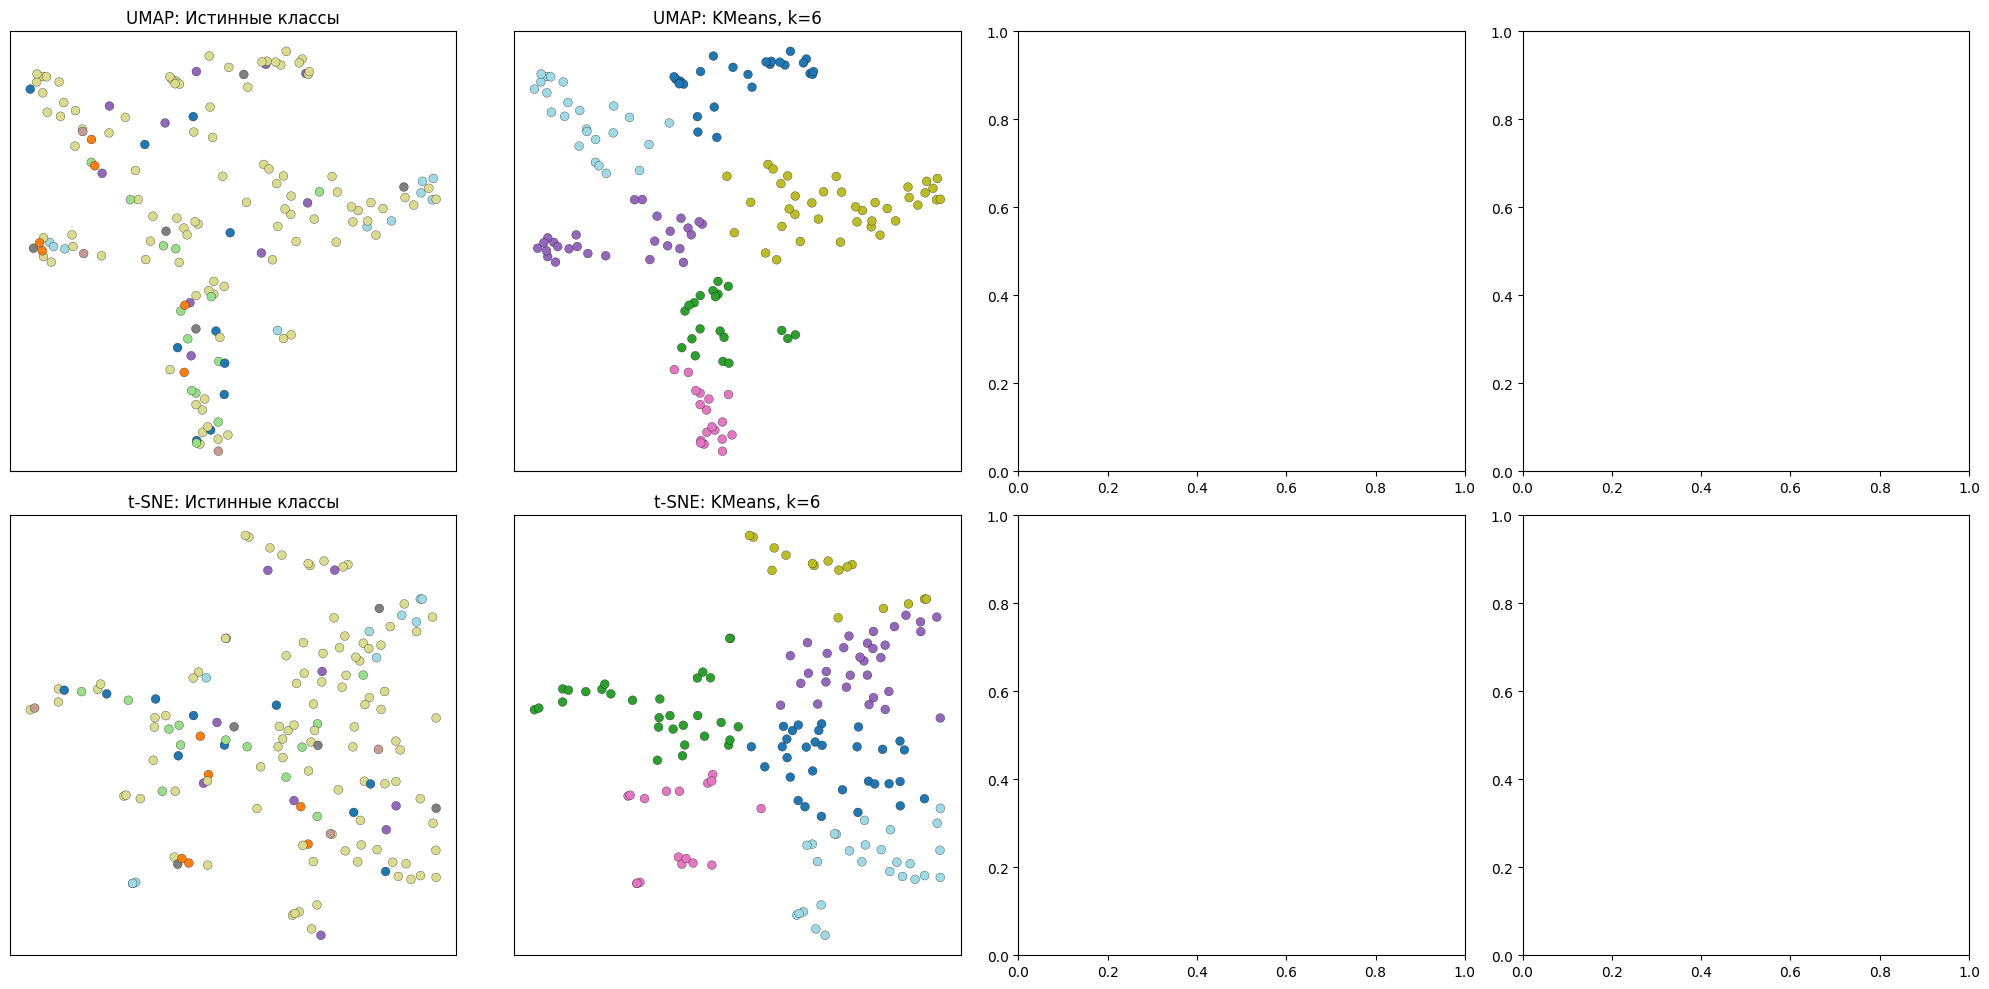

In [88]:
# Визуализация кластеров и истинных классов
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, (name, X2) in enumerate(embeddings.items()):
    # Истинные классы
    ax = axes[i*4 + 0]
    ax.scatter(X2[:, 0], X2[:, 1], c=y, cmap='tab20', s=40, edgecolor='k', linewidth=0.2)
    ax.set_title(f"{name}: Истинные классы", fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])
    
    k = 6
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X2)
    
    ax = axes[i*4 + 1]
    ax.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='tab20', s=40, edgecolor='k', linewidth=0.2)
    ax.set_title(f"{name}: KMeans, k={k}", fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

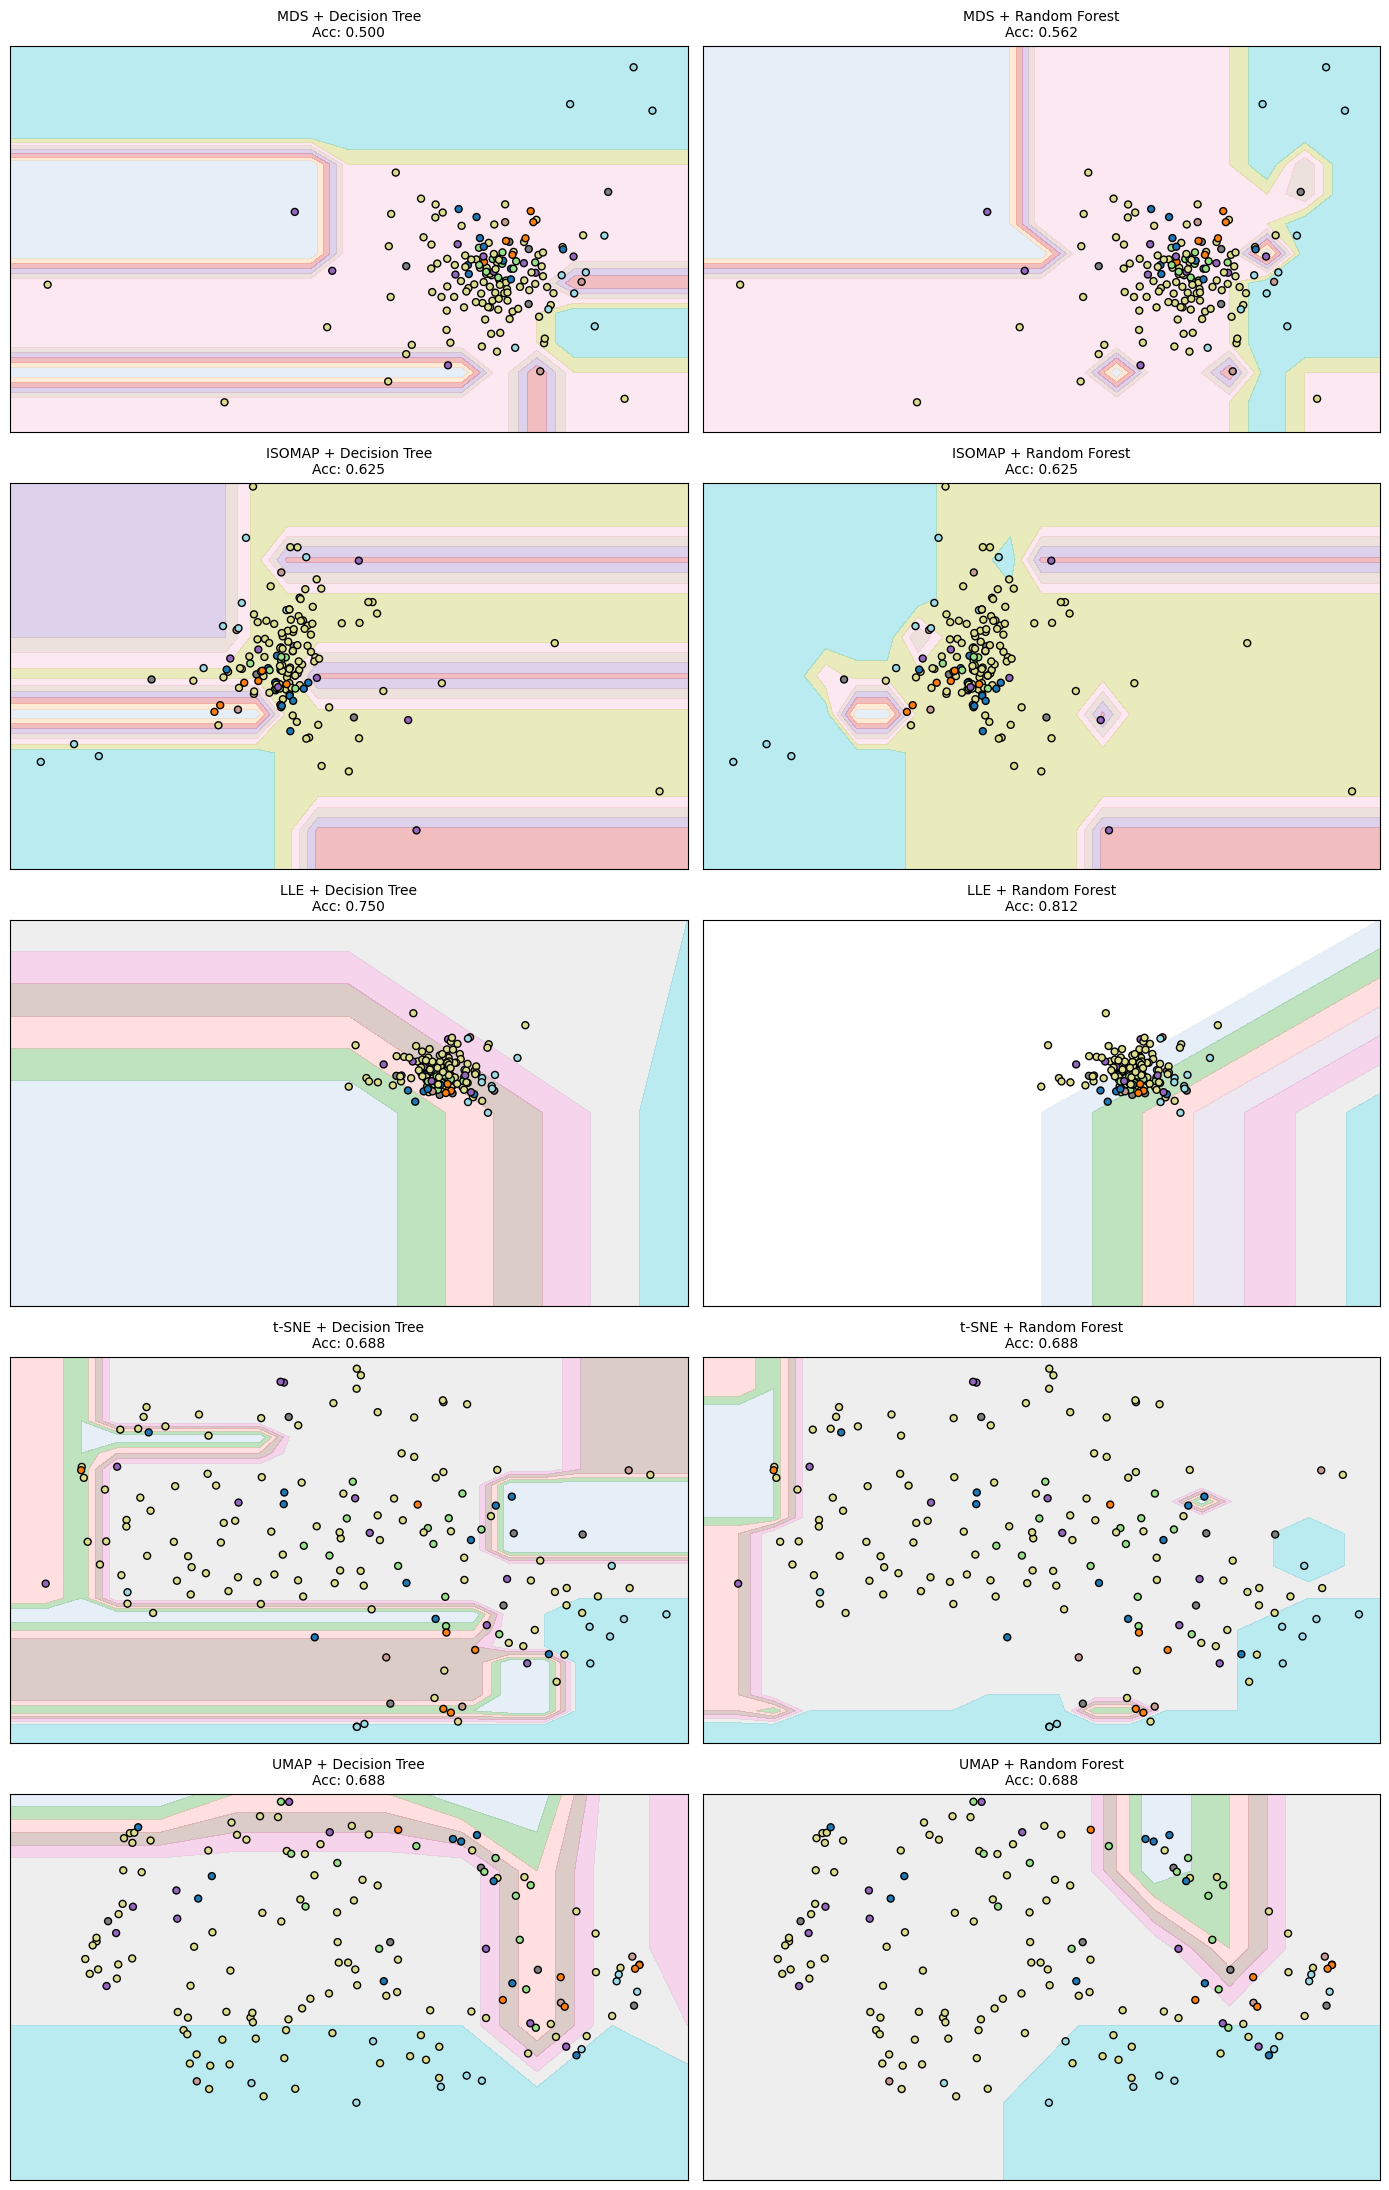


 СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ
Method         Model  Accuracy  F1 (weighted)  F1 (macro)
   MDS Decision Tree     0.500          0.479       0.238
   MDS Random Forest     0.562          0.469       0.107
ISOMAP Decision Tree     0.625          0.543       0.165
ISOMAP Random Forest     0.625          0.552       0.255
   LLE Decision Tree     0.750          0.668       0.410
   LLE Random Forest     0.812          0.731       0.553
 t-SNE Decision Tree     0.688          0.631       0.239
 t-SNE Random Forest     0.688          0.562       0.257
  UMAP Decision Tree     0.688          0.688       0.543
  UMAP Random Forest     0.688          0.636       0.403


In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # ← добавлено
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score  # ← f1_score добавлен

# Извлечение 2D-вложений
embeddings = {
    'MDS': methods['MDS'][0],
    'ISOMAP': methods['ISOMAP'][0],
    'LLE': methods['LLE'][0],
    't-SNE': methods['t-SNE'][0],
    'UMAP': methods['UMAP'][0]
}

# Целевая переменная
y = df['Industry'].astype('category').cat.codes

# Модели
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=6),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)  
}

# Графики
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = axes.ravel()

results = []  

idx = 0
for method_name, X2 in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1, random_state=42, stratify=y)
    
    for model_name, model in models.items():
        ax = axes[idx]
        idx += 1
        
        # Обучение
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  
        
        # Метрики
        acc = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        
        results.append({
            'Method': method_name,
            'Model': model_name,
            'Accuracy': acc,
            'F1 (weighted)': f1_weighted,
            'F1 (macro)': f1_macro
        })
        
        # Границы решений
        h = 1.0  # увеличил шаг для скорости
        x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
        y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='tab20')
        ax.scatter(X2[:, 0], X2[:, 1], c=y, cmap='tab20', edgecolor='k', s=25)
        ax.set_title(f"{method_name} + {model_name}\nAcc: {acc:.3f}", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

# Вывод таблицы
results_df = pd.DataFrame(results)
print("\n СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ")
print(results_df.round(3).to_string(index=False))